# Assignment 3: Recurrent Neural Network (RNN) {-}

This assignment aims at familiarizing you with training, validating and testing Recurrent Neural Networks (RNNs). Here are the BASIC requirements of the assignment:

BASIC requirements:
- Load the data.
- Analyze the data.
- Process the data.
- Build a RNN model using GRU (https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) instead of LSTM as in the demo code.
- Train and validate the RNN model (with GRU) to perform the movie review classification.
- Evaluate the performance of the model on the test set.
- Compare the accuracy and the running time between GRU and LSTM.
- Visualize the model behaviour during the training.

EXTRA CREDIT if all of the following requirements are fulfilled:
- Build a RNN model using Bi-LSTM (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Compare the accuracy and the running time between Bi-LSTM and the others (GRU, LSTM).
- Build a RNN model using 1D-Convolution (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D). Compare the accuracy and the running time between 1D-Convolution and the others (Bi-LSTM, GRU, LSTM).
- Apply transfer learning with the pre-trained word vectors GloVe (https://nlp.stanford.edu/projects/glove/). Observe the accuracy of the model with and without using transfer learning, then give conclusion.

The dataset you will be working on is imdb_reviews. This dataset is a large movie review dataset. This dataset is for binary sentiment classification containing a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. All the reviews have either a positive or negative sentiment. Reference: http://ai.stanford.edu/~amaas/data/sentiment/

Each data sample contains:
- label (tf.int64)
- text (tf.string)

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-assignment3-notebook.ipynb: Jupyter notebook containing source code.

The submission folder is named DL4AI-\<StudentID>-Assignment3 (e.g., DL4AI-2012345-Assigment3) and then compressed with the same name.

### Evaluation {-}
Assignment evaluation will be conducted on how you accomplish the assignment requirements. The model accuracy on the test set is one of the most important evaluation criteria. Therefore try to push it as high as possible. In addition, your code should conform to a Python coding convention such as PEP-8.

### Deadline {-}
Please visit Canvas for details.

#Getting Started

In [1]:
# Note: to enable GPU training in Colab, go to Runtime > Change runtime type > Hardware acceleration > Choose GPU from the drop-down list.

# Download tensorflow datasets
#!pip install tensorflow_datasets

# Import libraries
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [2]:
# Load the IMDB movie review dataset, return text (movie review) and label (positive/negative)
train_dataset, val_dataset, test_dataset = tfds.load(name="imdb_reviews", split=('train[:80%]', 'train[80%:]', 'test'), as_supervised=True)

print("Training set: ", len(train_dataset), "samples")
print("Validation set: ", len(val_dataset), "samples")
print("Test set: ", len(test_dataset), "samples")

Training set:  20000 samples
Validation set:  5000 samples
Test set:  25000 samples


In [3]:
# Show same samples in the training set
for example, label in train_dataset.take(3):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

In [4]:
### Convert Tensorflow Dataset to numpy arrays of feature vector X and label y

# Convert training set
train_ds_numpy = tfds.as_numpy(train_dataset) # Convert TF Dataset to an iterable of numpy array
train_numpy = np.vstack(list(train_ds_numpy)) # Stack to full numpy array
X_train = np.array(list(map(lambda x: x[0], train_numpy))) # Extract review (index 0) from numpy vector
y_train = np.array(list(map(lambda x: x[1], train_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector and convert grom string to number
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))

# Convert validation set
val_ds_numpy = tfds.as_numpy(val_dataset) # Convert TF Dataset to an iterable of numpy array
val_numpy = np.vstack(list(val_ds_numpy)) # Stack to full numpy array
X_val = np.array(list(map(lambda x: x[0], val_numpy))) # Extract review (index 0) from numpy vector
y_val = np.array(list(map(lambda x: x[1], val_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector
print("X_val shape: " + str(X_val.shape))
print("y_val shape: " + str(y_val.shape))

# Convert test set
test_ds_numpy = tfds.as_numpy(test_dataset) # Convert TF Dataset to an iterable of numpy array
test_numpy = np.vstack(list(test_ds_numpy)) # Stack to full numpy array
X_test = np.array(list(map(lambda x: x[0], test_numpy))) # Extract review (index 0) from numpy vector
y_test = np.array(list(map(lambda x: x[1], test_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (20000,)
y_train shape: (20000,)
X_val shape: (5000,)
y_val shape: (5000,)
X_test shape: (25000,)
y_test shape: (25000,)


#Encode the text

In [5]:
### TextVectorization layer maps text features to integer sequences.
# Set vocabulary size for the training data
VOCAB_SIZE = 1000

# Initialize the TextVectorization layer for raw text encoding
text_encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE) # Maximum size of the vocabulary

# Feed training text to adapt() method to calculate the layer's vocabulary 
text_encoder.adapt(X_train)

In [6]:
# Show the first 20 tokens. After the padding ('') and unknown ([UNK]) tokens they're sorted by frequency.
vocab = np.array(text_encoder.get_vocabulary()) # Get the vocabulary of the training set after the adaptation
print("Vocabulary size:", vocab.shape)
vocab[:20] # Show the first 20 tokens (sorted by frequency) in the vocabulary

Vocabulary size: (1000,)


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [7]:
### Example of how a text vectorization layer works. It maps strings to integers.

# Create the model that uses the text vectorization layer
model_encoder = tf.keras.models.Sequential()

# Creating an explicit input layer.
# It needs to have a shape of (1,) (because we need to guarantee that there is exactly one string input per batch),
model_encoder.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# The first (unique) layer in the model is the vectorization layer.
# After this layer, we have a tensor of shape (batch_size, max_len) containing vocab indices.
model_encoder.add(text_encoder)

# The model can map strings to integers, and you can add an embedding layer to map these integers to learned embeddings.
test_data = [["I want to drink"], ["I do not want to eat but I want to sleep"]]
model_encoder.predict(test_data)

# Note: The tensors of indices are zero-padded to the longest sequence in the batch,
# to make sure that all tensors of indices have the same size (for batching purpose).

1/1 [==============================] - 0s 125ms/step


array([[ 10, 179,   6,   1,   0,   0,   0,   0,   0,   0,   0],
       [ 10,  79,  22, 179,   6,   1,  19,  10, 179,   6,   1]])

# Build models

In [8]:
def gru_model():
  # Initialize a sequential model since all the layers in the model only have single input and produce single output
  model = tf.keras.Sequential([
      text_encoder, # Text encoder layer, i.e., TextVectorization layer
      tf.keras.layers.Embedding( # Text embedding layer, i.e., turns positive integers (indexes) into dense vectors of fixed size.
          input_dim=len(text_encoder.get_vocabulary()), # Get the size of word vocabulary (positive integers), VOCAB_SIZE.
          output_dim=64, # Fixed size of the output embedding vectors which is fed as input of LSTM layer.
          mask_zero=True), # Whether or not the input value 0 (the zero-padding) should be masked out
          # Hence if mask_zero = True, index 0 cannot be used in the vocabulary (input_dim = vocabulary size + 1)
      tf.keras.layers.GRU(units=64), # Output dimension of LSTM layer
      tf.keras.layers.Dense(64, activation='relu'), # Dense layer
      tf.keras.layers.Dense(1, activation='sigmoid') # Classification output
  ])

  # Summarize the model
  model.summary()

  # The embedding layer uses masking to handle the varying sequence-lengths
  # Check if the layers after the Embedding supports masking
  print([layer.supports_masking for layer in model.layers])
  return model

In [9]:
def lstm_model():
  # Initialize a sequential model since all the layers in the model only have single input and produce single output
  model = tf.keras.Sequential([
      text_encoder, # Text encoder layer, i.e., TextVectorization layer
      tf.keras.layers.Embedding( # Text embedding layer, i.e., turns positive integers (indexes) into dense vectors of fixed size.
          input_dim=len(text_encoder.get_vocabulary()), # Get the size of word vocabulary (positive integers), VOCAB_SIZE.
          output_dim=64, # Fixed size of the output embedding vectors which is fed as input of LSTM layer.
          mask_zero=True), # Whether or not the input value 0 (the zero-padding) should be masked out
          # Hence if mask_zero = True, index 0 cannot be used in the vocabulary (input_dim = vocabulary size + 1)
      tf.keras.layers.LSTM(units=64), # Output dimension of LSTM layer
      tf.keras.layers.Dense(64, activation='relu'), # Dense layer
      tf.keras.layers.Dense(1, activation='sigmoid') # Classification output
  ])

  # Summarize the model
  model.summary()

  # Calculate the number of parameters of each layer
  # Embedding = input_dim * output_dim = 1,000*64 = 64,000
  # LSTM = 4*(input_dim * output_dim + output_dim + output_dim^2) = 4*(64*64+64+64^2) = 33,024
  # dense = (input_dim + 1) * output_dim = (64 + 1) * 64 = 4,160

  # The embedding layer uses masking to handle the varying sequence-lengths
  # Check if the layers after the Embedding supports masking
  print([layer.supports_masking for layer in model.layers])
  return model

In [10]:
def bi_lstm_model():

  # Initialize a sequential model since all the layers in the model only have single input and produce single output
  model = tf.keras.Sequential([
      text_encoder, # Text encoder layer, i.e., TextVectorization layer
      tf.keras.layers.Embedding( # Text embedding layer, i.e., turns positive integers (indexes) into dense vectors of fixed size.
          input_dim=len(text_encoder.get_vocabulary()), # Get the size of word vocabulary (positive integers), VOCAB_SIZE.
          output_dim=64, # Fixed size of the output embedding vectors which is fed as input of LSTM layer.
          mask_zero=True), # Whether or not the input value 0 (the zero-padding) should be masked out
          # Hence if mask_zero = True, index 0 cannot be used in the vocabulary (input_dim = vocabulary size + 1)
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)), # Output dimension of Bi-LSTM layer
      tf.keras.layers.Dense(64, activation='relu'), # Dense layer
      tf.keras.layers.Dense(1, activation='sigmoid') # Classification output
  ])

  # Summarize the model
  model.summary()

  # The embedding layer uses masking to handle the varying sequence-lengths
  # Check if the layers after the Embedding supports masking
  print([layer.supports_masking for layer in model.layers])
  return model

In [11]:
def cnn_model():
  # Initialize a sequential model since all the layers in the model only have single input and produce single output
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(1,), dtype=tf.string),
      text_encoder, # Text encoder layer, i.e., TextVectorization layer
      tf.keras.layers.Embedding( # Text embedding layer, i.e., turns positive integers (indexes) into dense vectors of fixed size.
          input_dim=len(text_encoder.get_vocabulary()), # Get the size of word vocabulary (positive integers), VOCAB_SIZE.
          output_dim=64, # Fixed size of the output embedding vectors which is fed as input of LSTM layer.
          mask_zero=True), # Whether or not the input value 0 (the zero-padding) should be masked out
          # Hence if mask_zero = True, index 0 cannot be used in the vocabulary (input_dim = vocabulary size + 1)
      tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'), # 1D convolutional layer
      tf.keras.layers.GlobalMaxPooling1D(), # Max-pooling layer
      tf.keras.layers.Dense(64, activation='relu'), # Dense layer
      tf.keras.layers.Dense(1, activation='sigmoid') # Classification output
  ])

  # Summarize the model
  model.summary()

  # The embedding layer uses masking to handle the varying sequence-lengths
  # Check if the layers after the Embedding supports masking
  print([layer.supports_masking for layer in model.layers])
  return model


In [12]:
def compile(model):
  # Set up dynamic memory allocation for GPU
  # physical_devices = tf.config.list_physical_devices('GPU')
  # try:
  #   tf.config.experimental.set_memory_growth(physical_devices[0], True)
  # except:
  #   pass
  # Compile the model
  model.compile(loss='binary_crossentropy', # Binary classification loss
                optimizer=tf.keras.optimizers.Adam(1e-3), # Optimizer
                metrics=['accuracy']) # Evaluation metric

  # Train the model
  start_time = time.time() # Start time
  history = model.fit(X_train, y_train, epochs=10, batch_size = 1024, validation_data=(X_val, y_val)) # Here the test dataset is used as validtion set
  end_time = time.time() # End time

  training_time = end_time - start_time # Calculate the training time
  print("Training time: {:.2f} seconds".format(training_time)) # Print the training time
  return history, training_time

In [13]:
def plot_loss(history):
  # Visualize the training and validation loss over epochs
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

In [14]:
def plot_acc(history):
  # Visualize the training and validation accuracy over epochs
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [15]:
def eva(model):
  # Evaluate the model on the test set
  test_loss, test_acc = model.evaluate(X_test, y_test)
  print('Test Loss:', test_loss)
  print('Test Accuracy:', test_acc)
  return test_loss, test_acc

In [16]:
def predict(model):
  # Make prediction on a new data sample
  sample_reviews = [('It is a cool movie. The graphics and the animation are awesome.'),
                    ('The movie was really bad. I would not recommend it to anyone.')]
  predictions = model.predict(np.array(sample_reviews))
  print(sample_reviews[0], 'Prediction: ', predictions[0])
  print(sample_reviews[1], 'Prediction: ', predictions[1])

# Train the GRU model

In [17]:
#initial the GRU model
gru_model = gru_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 93,185
Trainable params: 93,185
Non-trainable params: 0
__________________________________________________

In [18]:
#compile, train and calculate the training time for GRU Model
gru_history, gru_time = compile(gru_model)

Epoch 1/10
20/20 [==============================] - 12s 230ms/step - loss: 0.6905 - accuracy: 0.5443 - val_loss: 0.6832 - val_accuracy: 0.5940
Epoch 2/10
20/20 [==============================] - 3s 146ms/step - loss: 0.6369 - accuracy: 0.6593 - val_loss: 0.4999 - val_accuracy: 0.7630
Epoch 3/10
20/20 [==============================] - 3s 161ms/step - loss: 0.4475 - accuracy: 0.7964 - val_loss: 0.3852 - val_accuracy: 0.8268
Epoch 4/10
20/20 [==============================] - 4s 177ms/step - loss: 0.3673 - accuracy: 0.8423 - val_loss: 0.3614 - val_accuracy: 0.8452
Epoch 5/10
20/20 [==============================] - 3s 160ms/step - loss: 0.3330 - accuracy: 0.8614 - val_loss: 0.3548 - val_accuracy: 0.8510
Epoch 6/10
20/20 [==============================] - 3s 159ms/step - loss: 0.3191 - accuracy: 0.8702 - val_loss: 0.3482 - val_accuracy: 0.8532
Epoch 7/10
20/20 [==============================] - 3s 166ms/step - loss: 0.3090 - accuracy: 0.8754 - val_loss: 0.3542 - val_accuracy: 0.8520
Epoch

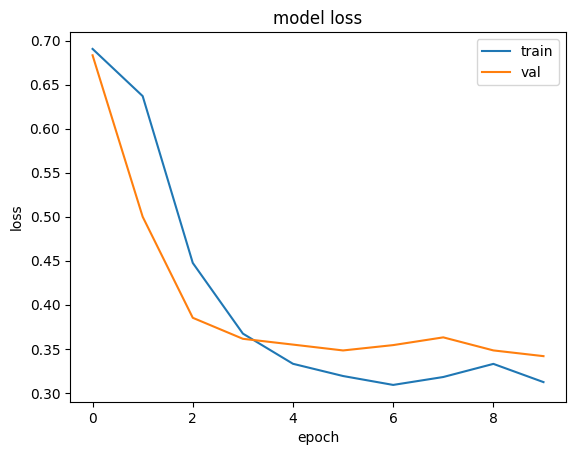

In [19]:
#plot the loss of training and validation set
plot_loss(gru_history)

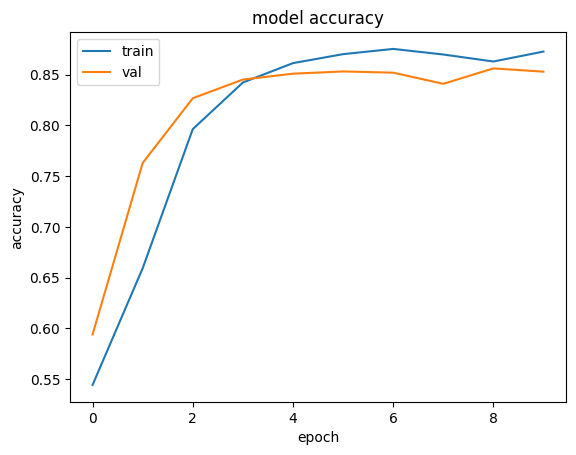

In [20]:
#plot the accuracy of training and validation set
plot_acc(gru_history)

In [21]:
#evaluate the GRU model on the test set
gru_loss, gru_acc = eva(gru_model)

782/782 [==============================] - 11s 14ms/step - loss: 0.3343 - accuracy: 0.8575
Test Loss: 0.33429789543151855
Test Accuracy: 0.8575199842453003


In [22]:
#make prediction on sample reviews
predict(gru_model)

1/1 [==============================] - 2s 2s/step
It is a cool movie. The graphics and the animation are awesome. Prediction:  [0.6936128]
The movie was really bad. I would not recommend it to anyone. Prediction:  [0.30182183]


# Train LSTM

In [23]:
#initialize LSTM model
lstm_model = lstm_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 101,249
Trainable params: 101,249
Non-trainable params: 0
________________________________________________

In [24]:
#compile, train and calculate the training time for LSTM Model
lstm_history, lstm_time = compile(lstm_model)

Epoch 1/10
20/20 [==============================] - 12s 277ms/step - loss: 0.6856 - accuracy: 0.5760 - val_loss: 0.6203 - val_accuracy: 0.7004
Epoch 2/10
20/20 [==============================] - 3s 162ms/step - loss: 0.5563 - accuracy: 0.7440 - val_loss: 0.4430 - val_accuracy: 0.8172
Epoch 3/10
20/20 [==============================] - 3s 153ms/step - loss: 0.3995 - accuracy: 0.8280 - val_loss: 0.3810 - val_accuracy: 0.8396
Epoch 4/10
20/20 [==============================] - 3s 162ms/step - loss: 0.3429 - accuracy: 0.8571 - val_loss: 0.3498 - val_accuracy: 0.8538
Epoch 5/10
20/20 [==============================] - 4s 182ms/step - loss: 0.3382 - accuracy: 0.8641 - val_loss: 0.3476 - val_accuracy: 0.8604
Epoch 6/10
20/20 [==============================] - 3s 165ms/step - loss: 0.3235 - accuracy: 0.8694 - val_loss: 0.3571 - val_accuracy: 0.8548
Epoch 7/10
20/20 [==============================] - 3s 146ms/step - loss: 0.3123 - accuracy: 0.8740 - val_loss: 0.3527 - val_accuracy: 0.8542
Epoch

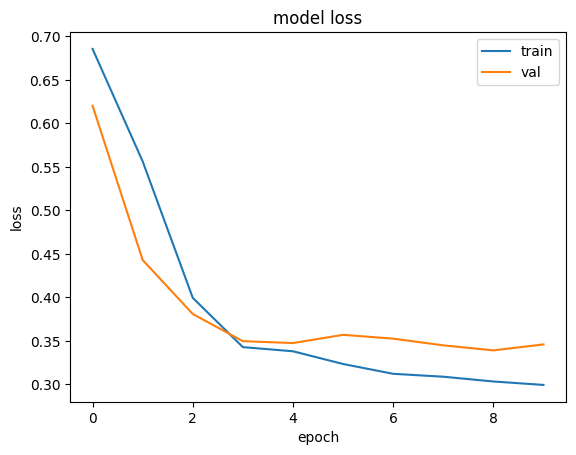

In [26]:
#plot the loss of training and validation set
plot_loss(lstm_history)

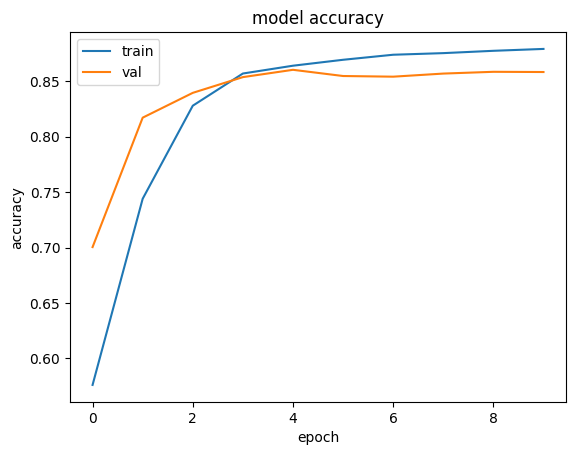

In [27]:
#plot the accuracy of training and validation set
plot_acc(lstm_history)

In [28]:
#evaluate the LSTM model on the test set
lstm_loss, lstm_acc = eva(lstm_model)

782/782 [==============================] - 11s 14ms/step - loss: 0.3377 - accuracy: 0.8609
Test Loss: 0.33766886591911316
Test Accuracy: 0.8608800172805786


In [29]:
#make prediction on sample reviews
predict(lstm_model)

1/1 [==============================] - 2s 2s/step
It is a cool movie. The graphics and the animation are awesome. Prediction:  [0.66798425]
The movie was really bad. I would not recommend it to anyone. Prediction:  [0.3028386]


#Train 1D-Conv model

In [30]:
#initialize 1D-Conv model
cnn_model = cnn_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          64000     
                                                                 
 conv1d (Conv1D)             (None, None, 64)          12352     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                

In [31]:
#compile, train and calculate the training time for CNN Model
cnn_history, cnn_time = compile(cnn_model)

Epoch 1/10
20/20 [==============================] - 25s 952ms/step - loss: 0.6853 - accuracy: 0.6574 - val_loss: 0.6709 - val_accuracy: 0.7278
Epoch 2/10
20/20 [==============================] - 10s 471ms/step - loss: 0.6396 - accuracy: 0.7771 - val_loss: 0.5889 - val_accuracy: 0.7946
Epoch 3/10
20/20 [==============================] - 5s 252ms/step - loss: 0.5151 - accuracy: 0.8066 - val_loss: 0.4407 - val_accuracy: 0.8112
Epoch 4/10
20/20 [==============================] - 4s 195ms/step - loss: 0.3893 - accuracy: 0.8313 - val_loss: 0.3619 - val_accuracy: 0.8422
Epoch 5/10
20/20 [==============================] - 5s 272ms/step - loss: 0.3293 - accuracy: 0.8596 - val_loss: 0.3448 - val_accuracy: 0.8468
Epoch 6/10
20/20 [==============================] - 4s 183ms/step - loss: 0.2957 - accuracy: 0.8782 - val_loss: 0.3312 - val_accuracy: 0.8552
Epoch 7/10
20/20 [==============================] - 4s 209ms/step - loss: 0.2684 - accuracy: 0.8929 - val_loss: 0.3196 - val_accuracy: 0.8616
Epoc

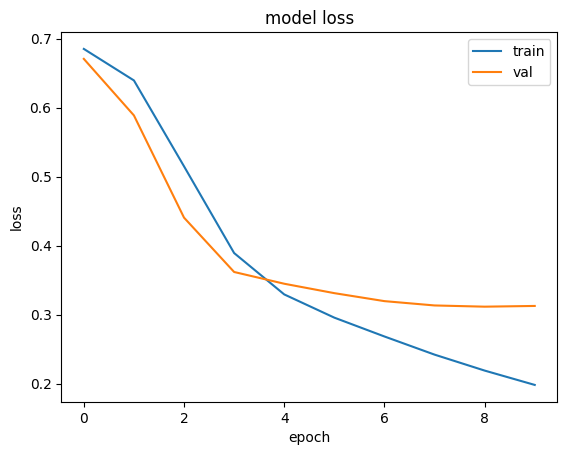

In [32]:
#plot the loss of training and validation set
plot_loss(cnn_history)

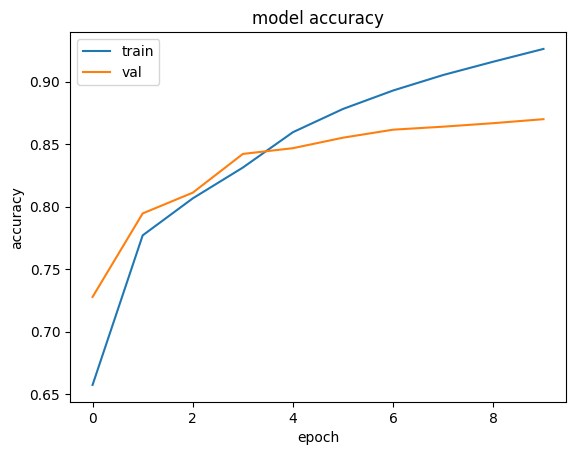

In [33]:
#plot the accuracy of training and validation set
plot_acc(cnn_history)

In [34]:
#evaluate the CNN model on the test set
cnn_loss, cnn_acc = eva(cnn_model)

782/782 [==============================] - 14s 18ms/step - loss: 0.3094 - accuracy: 0.8699
Test Loss: 0.3093608617782593
Test Accuracy: 0.869920015335083


In [35]:
#make prediction on sample reviews
predict(cnn_model)

1/1 [==============================] - 0s 145ms/step
It is a cool movie. The graphics and the animation are awesome. Prediction:  [0.98700863]
The movie was really bad. I would not recommend it to anyone. Prediction:  [0.00435981]


#Train Bi-LSTM model

In [36]:
#initialize Bi-LSTM model
bi_lstm_model = bi_lstm_model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-tr

In [37]:
#compile, train and calculate the training time for Bi-LSTM Model
bi_lstm_history, bi_lstm_time = compile(bi_lstm_model)

Epoch 1/10
20/20 [==============================] - 18s 410ms/step - loss: 0.6876 - accuracy: 0.5546 - val_loss: 0.6622 - val_accuracy: 0.6492
Epoch 2/10
20/20 [==============================] - 6s 281ms/step - loss: 0.5488 - accuracy: 0.7405 - val_loss: 0.4441 - val_accuracy: 0.8108
Epoch 3/10
20/20 [==============================] - 5s 250ms/step - loss: 0.3983 - accuracy: 0.8276 - val_loss: 0.3580 - val_accuracy: 0.8430
Epoch 4/10
20/20 [==============================] - 5s 246ms/step - loss: 0.3486 - accuracy: 0.8511 - val_loss: 0.3454 - val_accuracy: 0.8530
Epoch 5/10
20/20 [==============================] - 5s 257ms/step - loss: 0.3296 - accuracy: 0.8641 - val_loss: 0.3399 - val_accuracy: 0.8544
Epoch 6/10
20/20 [==============================] - 5s 251ms/step - loss: 0.3160 - accuracy: 0.8684 - val_loss: 0.3339 - val_accuracy: 0.8598
Epoch 7/10
20/20 [==============================] - 5s 272ms/step - loss: 0.3085 - accuracy: 0.8712 - val_loss: 0.3342 - val_accuracy: 0.8574
Epoch

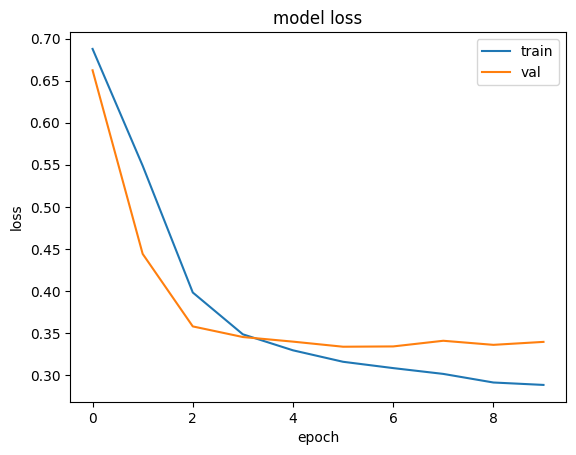

In [38]:
#plot the loss of training and validation set
plot_loss(bi_lstm_history)

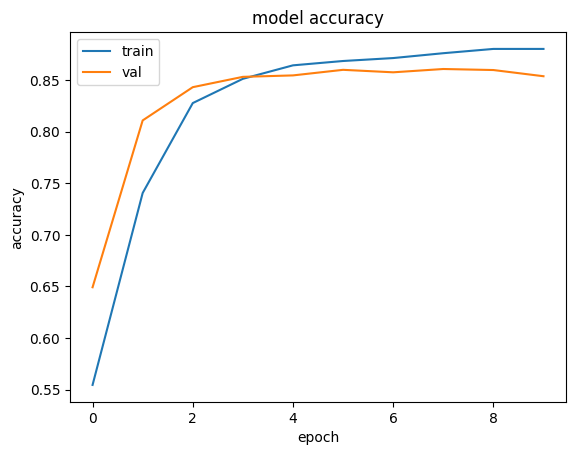

In [39]:
#plot the accuracy of training and validation set
plot_acc(bi_lstm_history)

In [40]:
#evaluate the BI-LSTM model on the test set
bi_lstm_loss, bi_lstm_acc = eva(bi_lstm_model)

782/782 [==============================] - 18s 23ms/step - loss: 0.3298 - accuracy: 0.8574
Test Loss: 0.3298450708389282
Test Accuracy: 0.8574399948120117


In [41]:
#make prediction on sample reviews
predict(bi_lstm_model)

1/1 [==============================] - 2s 2s/step
It is a cool movie. The graphics and the animation are awesome. Prediction:  [0.68535995]
The movie was really bad. I would not recommend it to anyone. Prediction:  [0.19860922]


# Apply transfer learning

In [42]:
# Load the pre-trained GloVe word vectors
from tensorflow.keras.datasets import imdb
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip
glove_weights = 'glove.6B.50d.txt'
word_index = imdb.get_word_index()
embedding_matrix = np.zeros((VOCAB_SIZE,64))
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        word, *vector = line.split()
        if word in word_index and int(word_index[word]) < VOCAB_SIZE:
            embedding_matrix[int(word_index[word])] = np.array(vector, dtype=np.float32)[:64]

--2023-05-08 07:13:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-08 07:13:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-08 07:13:10--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [43]:
#check if the embedding matrix
print(embedding_matrix[5])

[-1.89700007e-01  5.00239991e-02  1.90840006e-01 -4.91839983e-02
 -8.97369981e-02  2.10060000e-01 -5.49520016e-01  9.83769968e-02
 -2.01350003e-01  3.42409998e-01 -9.26769972e-02  1.60999998e-01
 -1.32679999e-01 -2.81599998e-01  1.87370002e-01 -4.29589987e-01
  9.60389972e-01  1.39719993e-01 -1.07809997e+00  4.05180007e-01
  5.05389988e-01 -5.50639987e-01  4.84400004e-01  3.80439997e-01
 -2.90549989e-03 -3.49420011e-01 -9.96960029e-02 -7.83680022e-01
  1.03629994e+00 -2.31399998e-01 -4.71210003e-01  5.71259975e-01
 -2.14540005e-01  3.59580010e-01 -4.83190000e-01  1.08749998e+00
  2.85239995e-01  1.24470003e-01 -3.92480008e-02 -7.67320022e-02
 -7.63429999e-01 -3.24090004e-01 -5.74899971e-01 -1.08930004e+00
 -4.18110013e-01  4.51200008e-01  1.21119998e-01 -5.13670027e-01
 -1.33489996e-01 -1.13779998e+00 -2.87680000e-01  1.67740002e-01
  5.58040023e-01  1.53869998e+00  1.88590009e-02 -2.97210002e+00
 -2.42160007e-01 -9.24950004e-01  2.19919991e+00  2.82339990e-01
 -3.47799987e-01  5.16210

In [44]:
# Define the the model architecture
gru_model_trans = tf.keras.Sequential([
    text_encoder,
    tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=64,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True
    ),
    tf.keras.layers.GRU(units=64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

gru_model_trans.compile(loss='binary_crossentropy', # Binary classification loss
                optimizer=tf.keras.optimizers.Adam(1e-3), # Optimizer
                metrics=['accuracy']) # Evaluation metric

In [45]:
# Train the model with transfer learning
start_time_trans = time.time() # Start time
history_transfer = gru_model_trans.fit(X_train, y_train,
                             epochs=10, batch_size = 1024,
                             validation_data=(X_val, y_val))
end_time_trans = time.time() # End time

trans_time = end_time_trans - start_time_trans # Calculate the training time
print("Training time: {:.2f} seconds".format(trans_time)) # Print the training time

Epoch 1/10
20/20 [==============================] - 11s 283ms/step - loss: 0.6974 - accuracy: 0.5106 - val_loss: 0.6884 - val_accuracy: 0.5340
Epoch 2/10
20/20 [==============================] - 3s 154ms/step - loss: 0.6838 - accuracy: 0.5604 - val_loss: 0.6814 - val_accuracy: 0.5618
Epoch 3/10
20/20 [==============================] - 3s 163ms/step - loss: 0.6720 - accuracy: 0.5871 - val_loss: 0.6673 - val_accuracy: 0.5946
Epoch 4/10
20/20 [==============================] - 3s 176ms/step - loss: 0.6420 - accuracy: 0.6315 - val_loss: 0.6222 - val_accuracy: 0.6464
Epoch 5/10
20/20 [==============================] - 3s 150ms/step - loss: 0.5443 - accuracy: 0.7234 - val_loss: 0.4754 - val_accuracy: 0.7758
Epoch 6/10
20/20 [==============================] - 3s 162ms/step - loss: 0.4598 - accuracy: 0.7842 - val_loss: 0.4389 - val_accuracy: 0.8014
Epoch 7/10
20/20 [==============================] - 3s 160ms/step - loss: 0.4049 - accuracy: 0.8166 - val_loss: 0.3868 - val_accuracy: 0.8324
Epoch

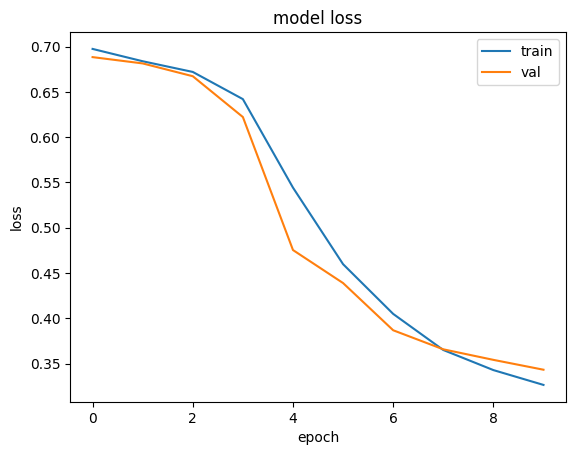

In [46]:
#plot the loss of training and validation set
plot_loss(history_transfer)

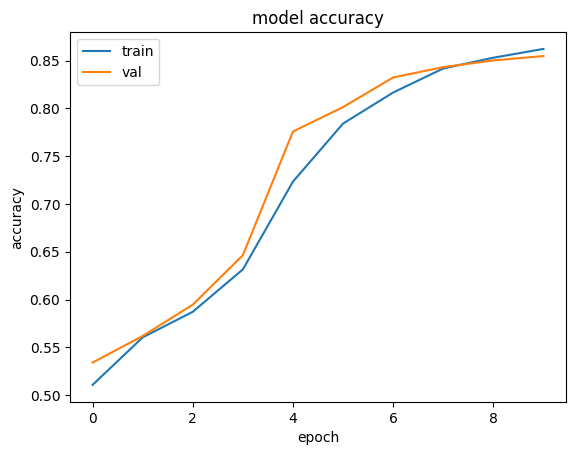

In [47]:
#plot the accuracy of training and validation set
plot_acc(history_transfer)

In [48]:
#evaluate the transfer learning model on the test set
trans_loss, trans_acc = eva(gru_model_trans)

782/782 [==============================] - 11s 14ms/step - loss: 0.3416 - accuracy: 0.8504
Test Loss: 0.34161999821662903
Test Accuracy: 0.8503599762916565


In [49]:
#make prediction on sample reviews
predict(gru_model_trans)

1/1 [==============================] - 2s 2s/step
It is a cool movie. The graphics and the animation are awesome. Prediction:  [0.81007785]
The movie was really bad. I would not recommend it to anyone. Prediction:  [0.4233493]


#Comparision between models

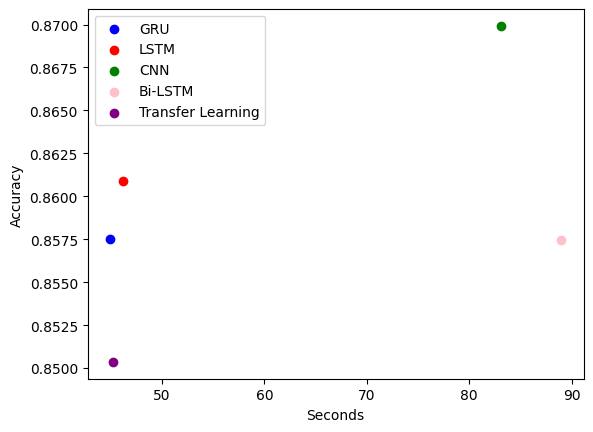

In [50]:
# Data for scatter plot
x = [gru_time, lstm_time, cnn_time, bi_lstm_time, trans_time]
y = [gru_acc, lstm_acc, cnn_acc, bi_lstm_acc, trans_acc]

# Plotting the scatter plot with different colors and labels
plt.scatter(gru_time, gru_acc, color='blue', label='GRU')
plt.scatter(lstm_time, lstm_acc, color='red', label='LSTM')
plt.scatter(cnn_time, cnn_acc, color='green', label='CNN')
plt.scatter(bi_lstm_time, bi_lstm_acc, color='pink', label='Bi-LSTM')
plt.scatter(trans_time, trans_acc, color='purple', label='Transfer Learning')
# Setting the x and y axis labels
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

We can see that the CNN model has the highest accuracy at around 0.87 but takes double the time to train. Interestingly, the GRU model with transfer learning does not perform better than the the GRU model without the transfer learning, so we could say that using transfer learning does not always guarantee a better model. With that being said, the gap between accuarcy of different models is not too big as the lowest is 0.85